In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from IPython.display import HTML
from joblib import Parallel, delayed

from modules.config import DPI, FIG_SIZE


In [2]:
from modules.random_walk_monte_carlo import RandomWalker

In [3]:
from modules.dla_algorithm import Diffusion, compare_omegas, plot_omega_comparison

# Test various $\eta$
We test 3 values of $\eta,0,1,2$ run $200$ growth iterations and the default value of $\omega = 1.8$.

We plot the resulting cluster and concentration of the grid cells.

Disclamer: execution of the following cell takes around 6 minutes.

In [4]:
grid_size = 100
growth_iterations = 200


def run_simulation_and_plot(eta):
    diffusion = Diffusion(grid_size, eta, initial_point="bottom")
    diffusion.run_simulation(growth_iterations)
    diffusion.plot(eta, save=True, filename=f"diffusion_eta_{eta}_200.png")


_ = Parallel(n_jobs=-2)(delayed(run_simulation_and_plot)(eta) for eta in [0, 1, 2])


Figure(640x480)
Figure(640x480)
Figure(640x480)


## Find optimal value of $\omega$
Next, we try find the approximate optimal value of $\omega$ for the three values of $\eta = 0,1,2$.

We start with initial guess of $\omega = 1.4, 1.6, 1.8, 1.9$ and run $20$ simulations with $50$ growth iterations for each combination of $\omega$ and $\eta$.

During each growth step, we solve the Lapsal equation using the **SOR** method and we check the number of iterations we had to do for **SOR** to converge. We then measure the performance of each $\omega$ by checking the total number of iterations we had to do in SOR and plot the results.

Disclamer: execution of each of the three following cells can take up to 30 minutes. Depending on the hardware.

30 simulations 15 min 

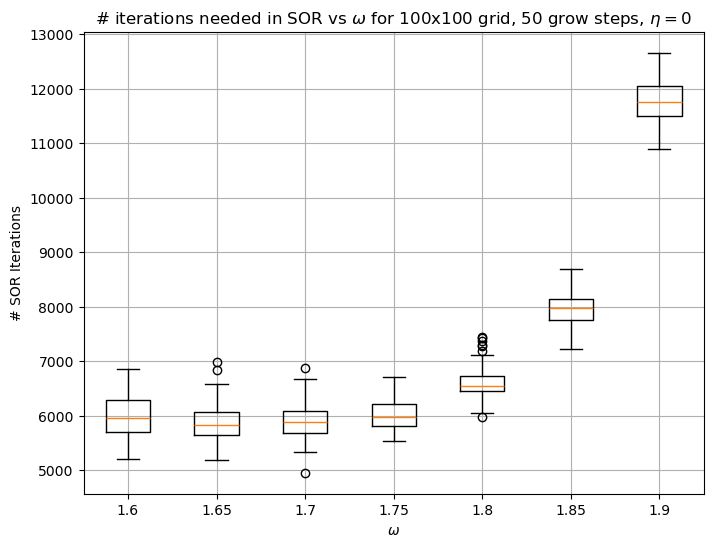

In [8]:
eta = 0
omegas = [1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9]
num_simulations = 100

results_omegas_eta_0 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(
    results_omegas_eta_0, omegas, eta, save=True, filename="omega_comparison_eta_0.png"
)


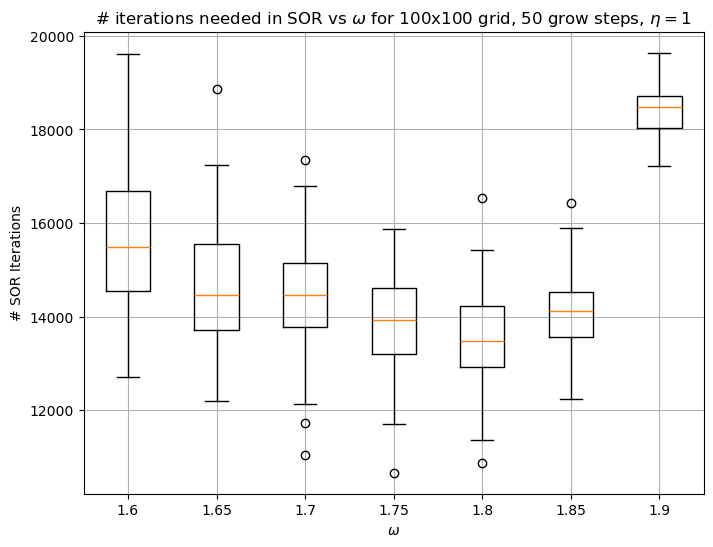

In [9]:
eta = 1
omegas = [1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9]
num_simulations = 100

results_omegas_eta_1 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(
    results_omegas_eta_1, omegas, eta, save=True, filename="omega_comparison_eta_1.png"
)

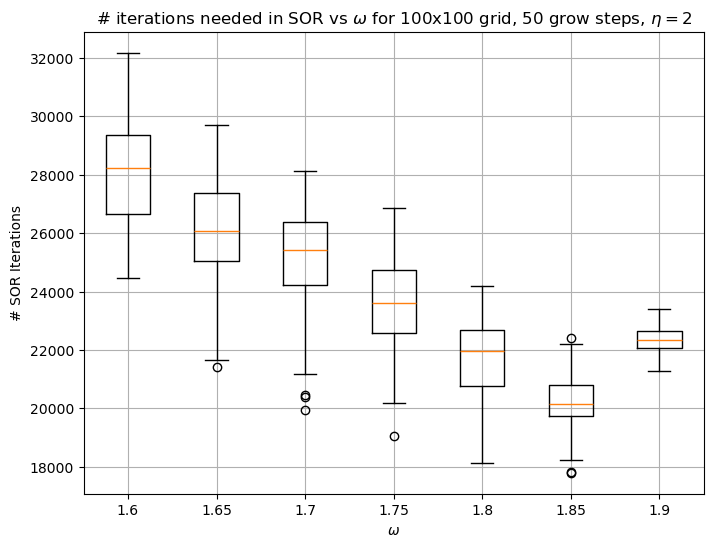

In [10]:
eta = 2
omegas = [1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9]
num_simulations = 100

results_omegas_eta_2 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(
    results_omegas_eta_2, omegas, eta, save=True, filename="omega_comparison_eta_2.png"
)

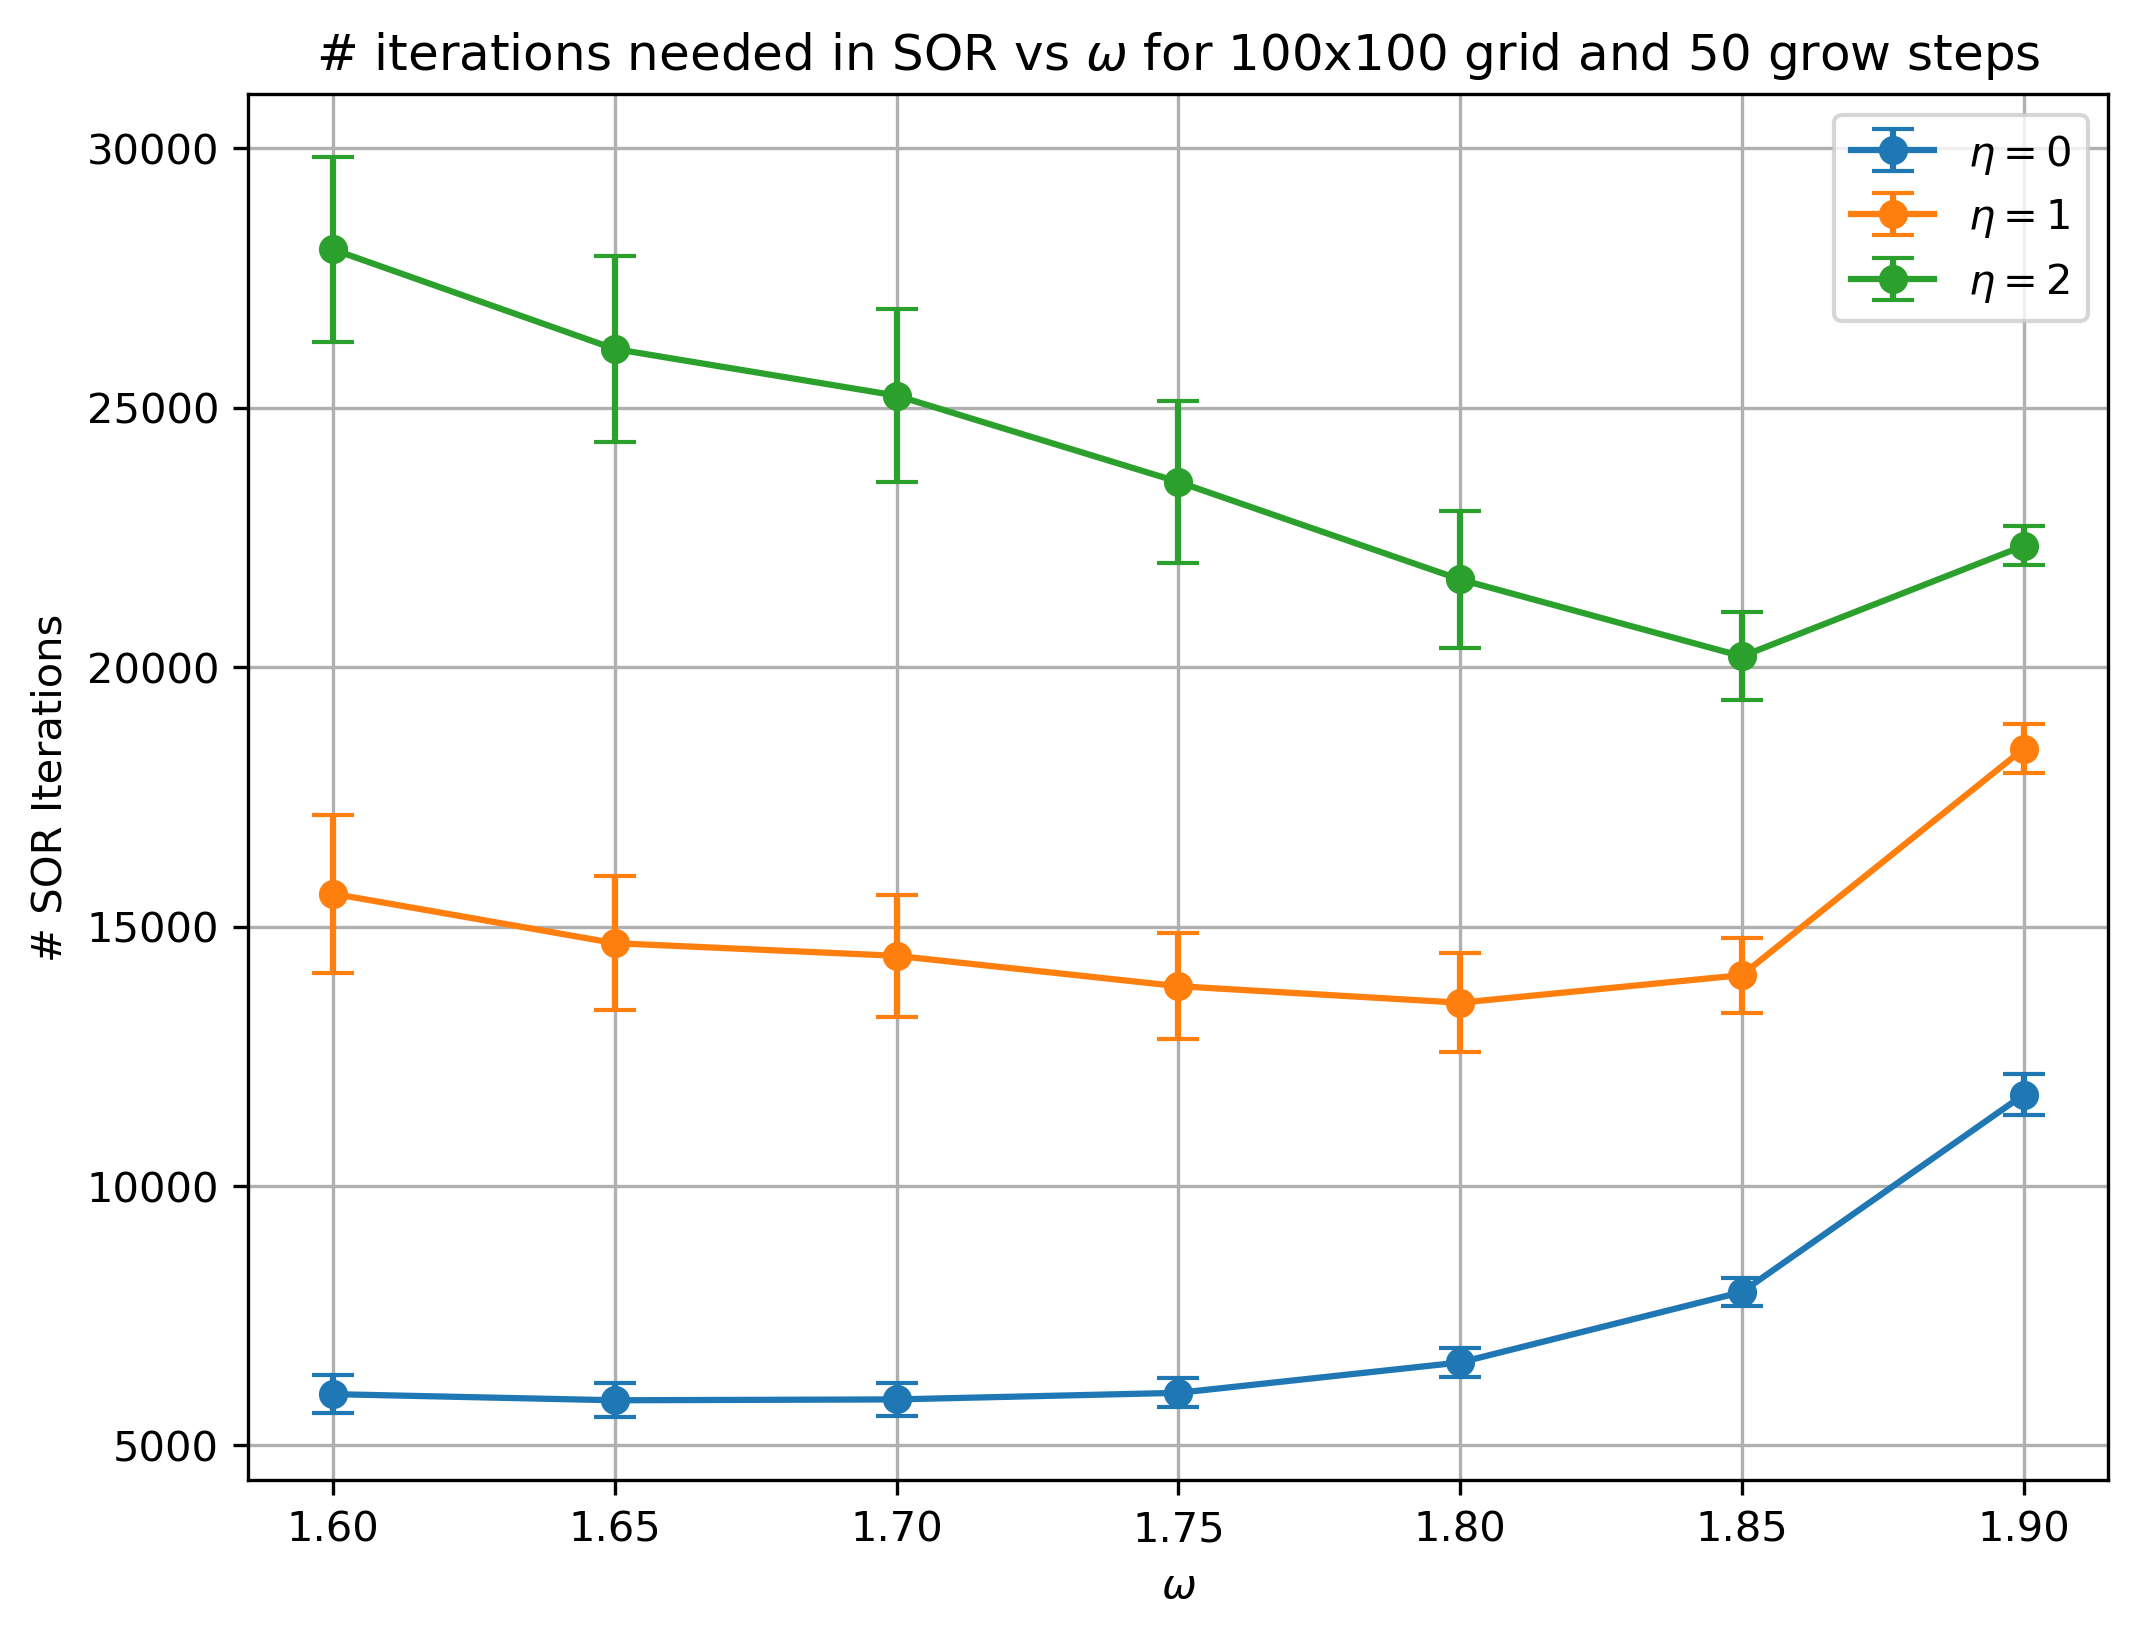

In [11]:
means_0 = np.mean(np.array(results_omegas_eta_0), axis=0)
stds_0 = np.std(np.array(results_omegas_eta_0), axis=0)

means_1 = np.mean(np.array(results_omegas_eta_1), axis=0)
stds_1 = np.std(np.array(results_omegas_eta_1), axis=0)

means_2 = np.mean(np.array(results_omegas_eta_2), axis=0)
stds_2 = np.std(np.array(results_omegas_eta_2), axis=0)

plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.errorbar(omegas, means_0, yerr=stds_0, fmt="o-", capsize=5, label=r"$\eta = 0$")
plt.errorbar(omegas, means_1, yerr=stds_1, fmt="o-", capsize=5, label=r"$\eta = 1$")
plt.errorbar(omegas, means_2, yerr=stds_2, fmt="o-", capsize=5, label=r"$\eta = 2$")
plt.xlabel(r"$\omega$")
plt.ylabel("# SOR Iterations")
plt.title(r"# iterations needed in SOR vs $\omega$ for 100x100 grid and 50 grow steps")
plt.legend()
plt.grid(True)
plt.savefig("results/omega_vs_sor_mean.png", dpi=300, bbox_inches="tight")
plt.show()

## Analysing the cluster shape
Lastly, we analyse the shape of the cluster so that we can compare it to the Monte Carlo simulation.

Again, for three values of $\eta=0,1,2$
and $200$ growth steps, we run $20$ simulations each and measure the size of the perimeter and the width and height of the cluster. We then plot our results. We use the optimal for each

found in the previous part.

Disclamer: execution of each of the three following cells can take up to 20 mins

In [14]:
grid_size = 100
growth_iterations = 200
num_simulations = 100


def run_simulation_and_measure(eta, omega):
    diffusion = Diffusion(grid_size, eta, initial_point="bottom")
    diffusion.run_simulation(growth_iterations, omega)

    return [
        diffusion.get_perimeter_size(),
        diffusion.get_width(),
        diffusion.get_height(),
    ]

In [37]:
# etas = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
# omegas = [1.65, 1.7, 1.75, 1.8, 1.81, 1.82, 1.83, 1.84, 1.85]

etas = np.linspace(0, 3, 10)
omegas = np.linspace(1.65, 1.85, 10)

clusters = [[] for _ in range(len(etas))]

for i, eta in enumerate(etas):
    clusters[i] = np.array(Parallel(n_jobs=-2)(
        delayed(run_simulation_and_measure)(eta, omegas[i]) for _ in range(num_simulations)
    ))

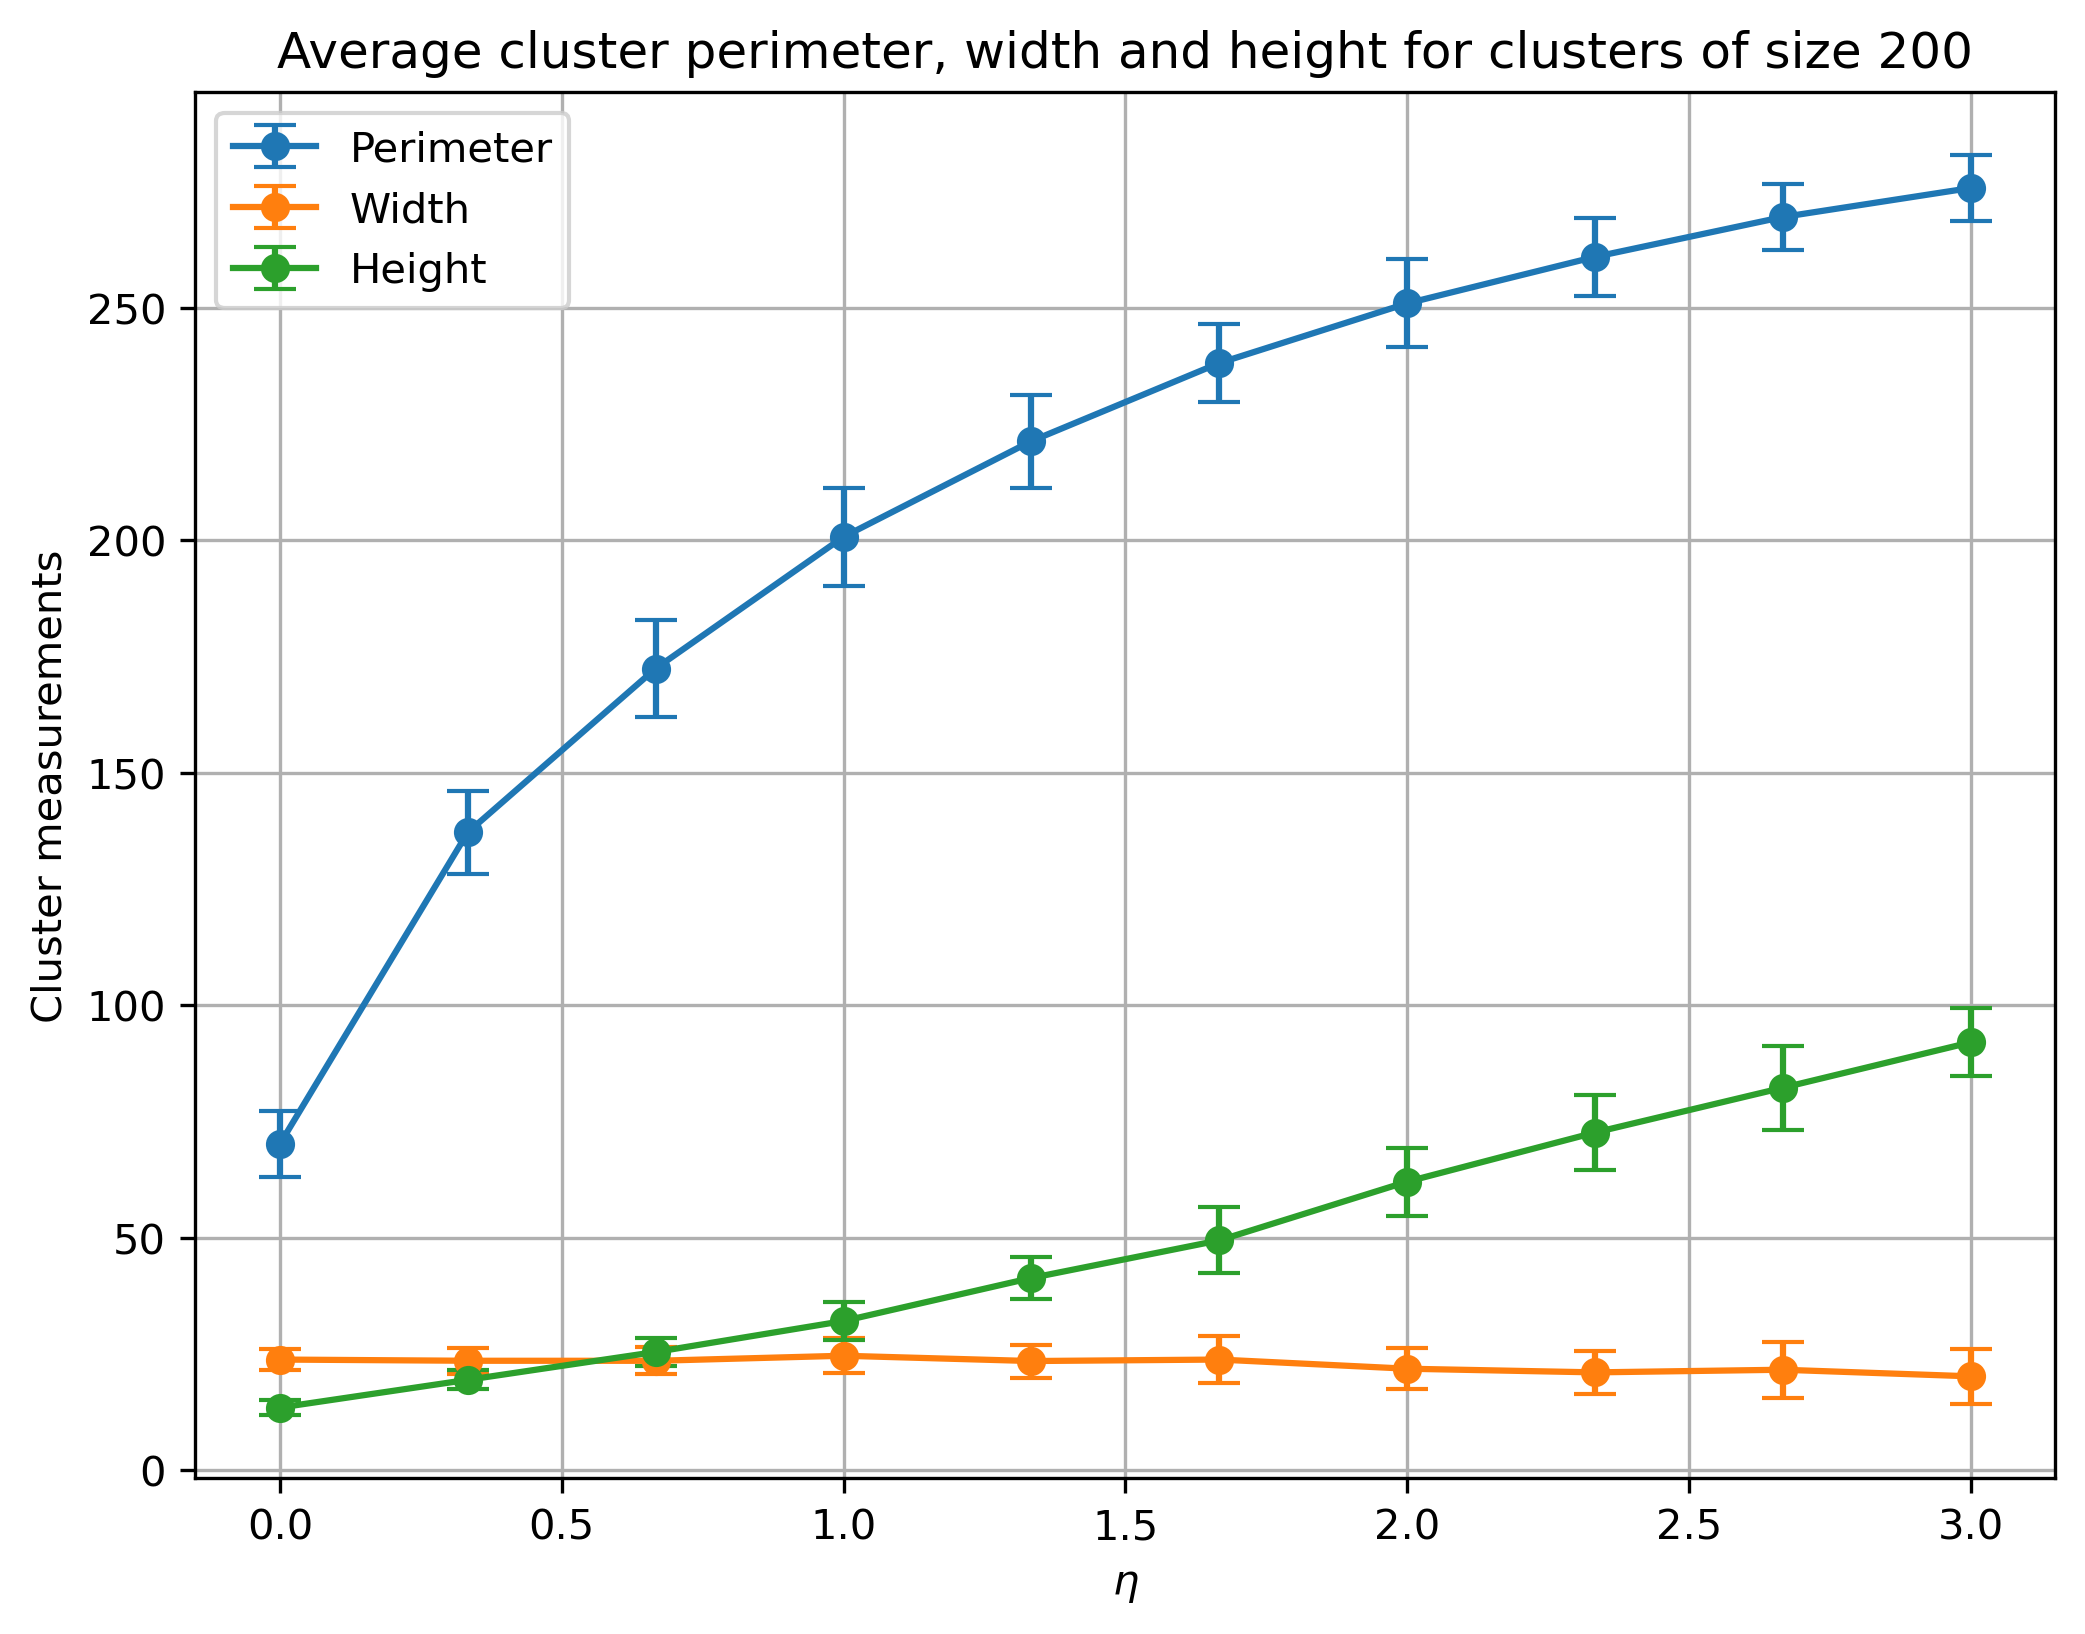

In [42]:
perimeters = [cluster_eta[:,0] for cluster_eta in clusters]
widths = [cluster_eta[:,1] for cluster_eta in clusters]
heights = [cluster_eta[:,2] for cluster_eta in clusters]

means_perimeter = np.mean(perimeters, axis=1)
stds_perimeter = np.std(perimeters, axis=1)

means_width = np.mean(widths, axis=1)
stds_width = np.std(widths, axis=1)

means_height = np.mean(heights, axis=1)
stds_height = np.std(heights, axis=1)

plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.errorbar(etas, means_perimeter, yerr=stds_perimeter, fmt="o-", capsize=5, label="Perimeter")
plt.errorbar(etas, means_width, yerr=stds_width, fmt="o-", capsize=5, label="Width")
plt.errorbar(etas, means_height, yerr=stds_height, fmt="o-", capsize=5, label="Height")
plt.xlabel(r"$\eta$")
plt.ylabel("Cluster measurements")
plt.title(r"Average cluster perimeter, width and height for clusters of size 200")
plt.legend()
plt.grid(True)
plt.savefig("results/average_dla_cluster_sizes.png", dpi=300, bbox_inches="tight")
plt.show()

In [40]:
print(heights[-1])

[91 77 99 89 99 99 88 99 87 87 99 88 99 99 89 84 81 87 93 82 73 87 91 89
 99 87 99 78 94 92 81 76 93 99 93 78 90 88 85 99 87 84 99 99 99 99 99 99
 96 79 95 99 99 84 99 88 99 99 94 94 96 99 92 99 99 85 99 84 85 99 99 99
 99 91 99 99 99 99 99 80 81 91 89 92 92 99 99 83 81 93 99 98 89 99 95 95
 99 79 96 78]


In [16]:
eta = 0
omega = 1.65

clusters_eta_0 = Parallel(n_jobs=-2)(
    delayed(run_simulation_and_measure)(eta, omega) for _ in range(num_simulations)
)

clusters_eta_0 = np.array(clusters_eta_0)

print(
    f"The average perimeter size for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[0] for cluster in clusters_eta_0])}"
)
print(
    f"The average width for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[1] for cluster in clusters_eta_0])}"
)
print(
    f"The average height for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[2] for cluster in clusters_eta_0])}"
)


The average perimeter size for cluster size 200 and η = 0 is 70.89
The average width for cluster size 200 and η = 0 is 24.09
The average height for cluster size 200 and η = 0 is 13.37


In [ ]:
eta = 1
omega = 1.8

clusters_eta_1 = Parallel(n_jobs=-2)(
    delayed(run_simulation_and_measure)(eta, omega) for _ in range(num_simulations)
)

clusters_eta_1 = np.array(clusters_eta_1)

print(
    f"The average perimeter size for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[0] for cluster in clusters_eta_1])}"
)
print(
    f"The average width for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[1] for cluster in clusters_eta_1])}"
)
print(
    f"The average height for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[2] for cluster in clusters_eta_1])}"
)


In [ ]:
eta = 2
omega = 1.85

clusters_eta_2 = Parallel(n_jobs=-2)(
    delayed(run_simulation_and_measure)(eta, omega) for _ in range(num_simulations)
)

clusters_eta_2 = np.array(clusters_eta_2)

print(
    f"The average perimeter size for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[0] for cluster in clusters_eta_2])}"
)
print(
    f"The average width for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[1] for cluster in clusters_eta_2])}"
)
print(
    f"The average height for cluster size {growth_iterations} and η = {eta} is {np.mean([cluster[2] for cluster in clusters_eta_2])}"
)


## Monte-Carlo Random Walker

For the Monte Carlo Random Walker system, we will be testing under the same conditions ast the DLA, where possible. The one parameter which can be varied, namely $p_{stick}$, will be tested for [0.25, 0.5, 0.75, 1]. Similarly, we will be investigating the height, width, and perimeter of the resulting clusters. 

Disclaimer: generating the results may take up to 1 hour. 

In [ ]:
grid_size = 100
steps = 10000000
num_simulations = 20
p_stick_values = [0.25, 0.5, 0.75, 1]

def run_single_simulation(p_stick, steps, grid_size):
    simulation = RandomWalker(N=grid_size, p_stick=p_stick, initial_point="bottom")
    simulation.run_simulation(steps)
    return simulation, len(simulation.cluster), simulation.get_perimeter_size(), simulation.get_width(), simulation.get_height()

results = []
final_simulations = {}

for p_stick in p_stick_values:
    cluster_sizes, perimeter_sizes, widths, heights = [], [], [], []

    for _ in tqdm(range(num_simulations), desc=f"Running p_stick={p_stick}", leave=True):
        simulation, cluster_size, perimeter_size, width, height = run_single_simulation(p_stick, steps, grid_size)

        cluster_sizes.append(cluster_size)
        perimeter_sizes.append(perimeter_size)
        widths.append(width)
        heights.append(height)

    final_simulations[p_stick] = simulation

    results.append({
        "p_stick": p_stick,
        "mean_cluster_size": np.mean(cluster_sizes),
        "std_cluster_size": np.std(cluster_sizes),
        "mean_perimeter_size": np.mean(perimeter_sizes),
        "std_perimeter_size": np.std(perimeter_sizes),
        "mean_width": np.mean(widths),
        "std_width": np.std(widths),
        "mean_height": np.mean(heights),
        "std_height": np.std(heights),
    })

df = pd.DataFrame(results)
df.to_csv("data/random_walk_results.csv", index=False)

Running p_stick=1: 100%|██████████| 20/20 [08:25<00:00, 25.29s/it]


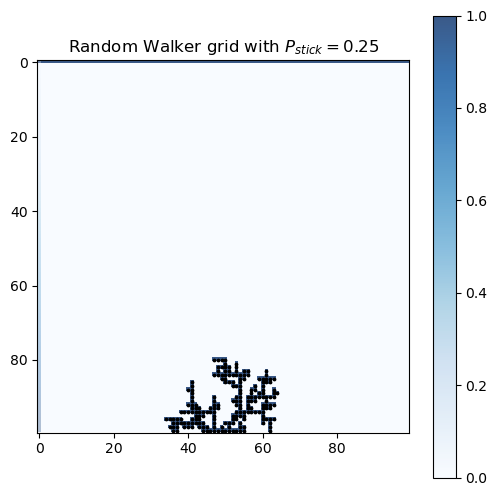

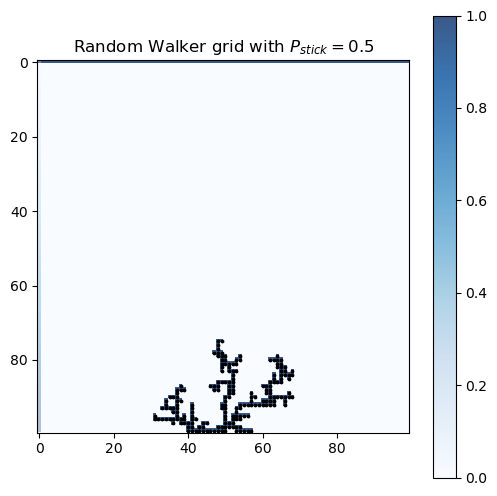

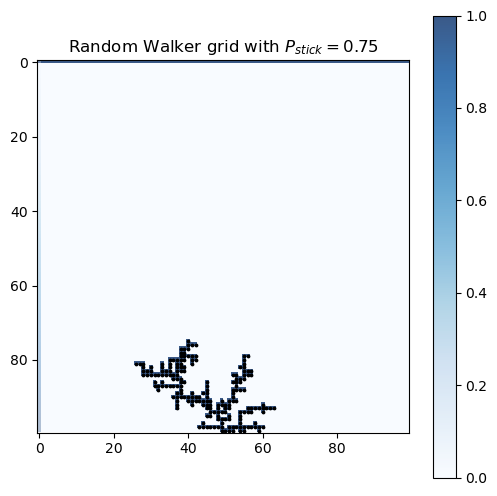

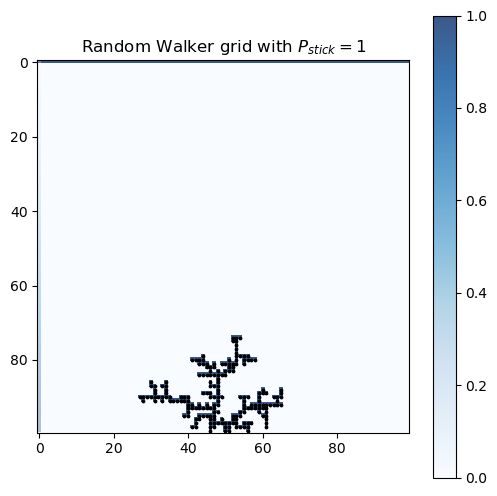

In [11]:
for p_stick, simulation in final_simulations.items():
    fig, ax = plt.subplots(figsize=(6, 6))

    fixed_grid = np.where(simulation.grid == -1, 1, simulation.grid)

    norm_grid = (fixed_grid - np.min(fixed_grid)) / (np.max(fixed_grid) - np.min(fixed_grid))

    im = ax.imshow(norm_grid, cmap="Blues", alpha=0.8)

    gradient = np.linspace(0, 1, simulation.grid.shape[0])[:, None]  # Vertical gradient
    ax.imshow(gradient, cmap="Blues", alpha=0.3)

    x_points = [coords[1] for coords in simulation.cluster]
    y_points = [coords[0] for coords in simulation.cluster]
    ax.scatter(x_points, y_points, color="black", s=3)
    ax.set_title(r"Random Walker grid with $P_{stick} = $" + f"{p_stick}")

    plt.colorbar(im)
    plt.savefig(f"results/cluster_pstick_{p_stick}.png", dpi=300, bbox_inches="tight")
    plt.show()

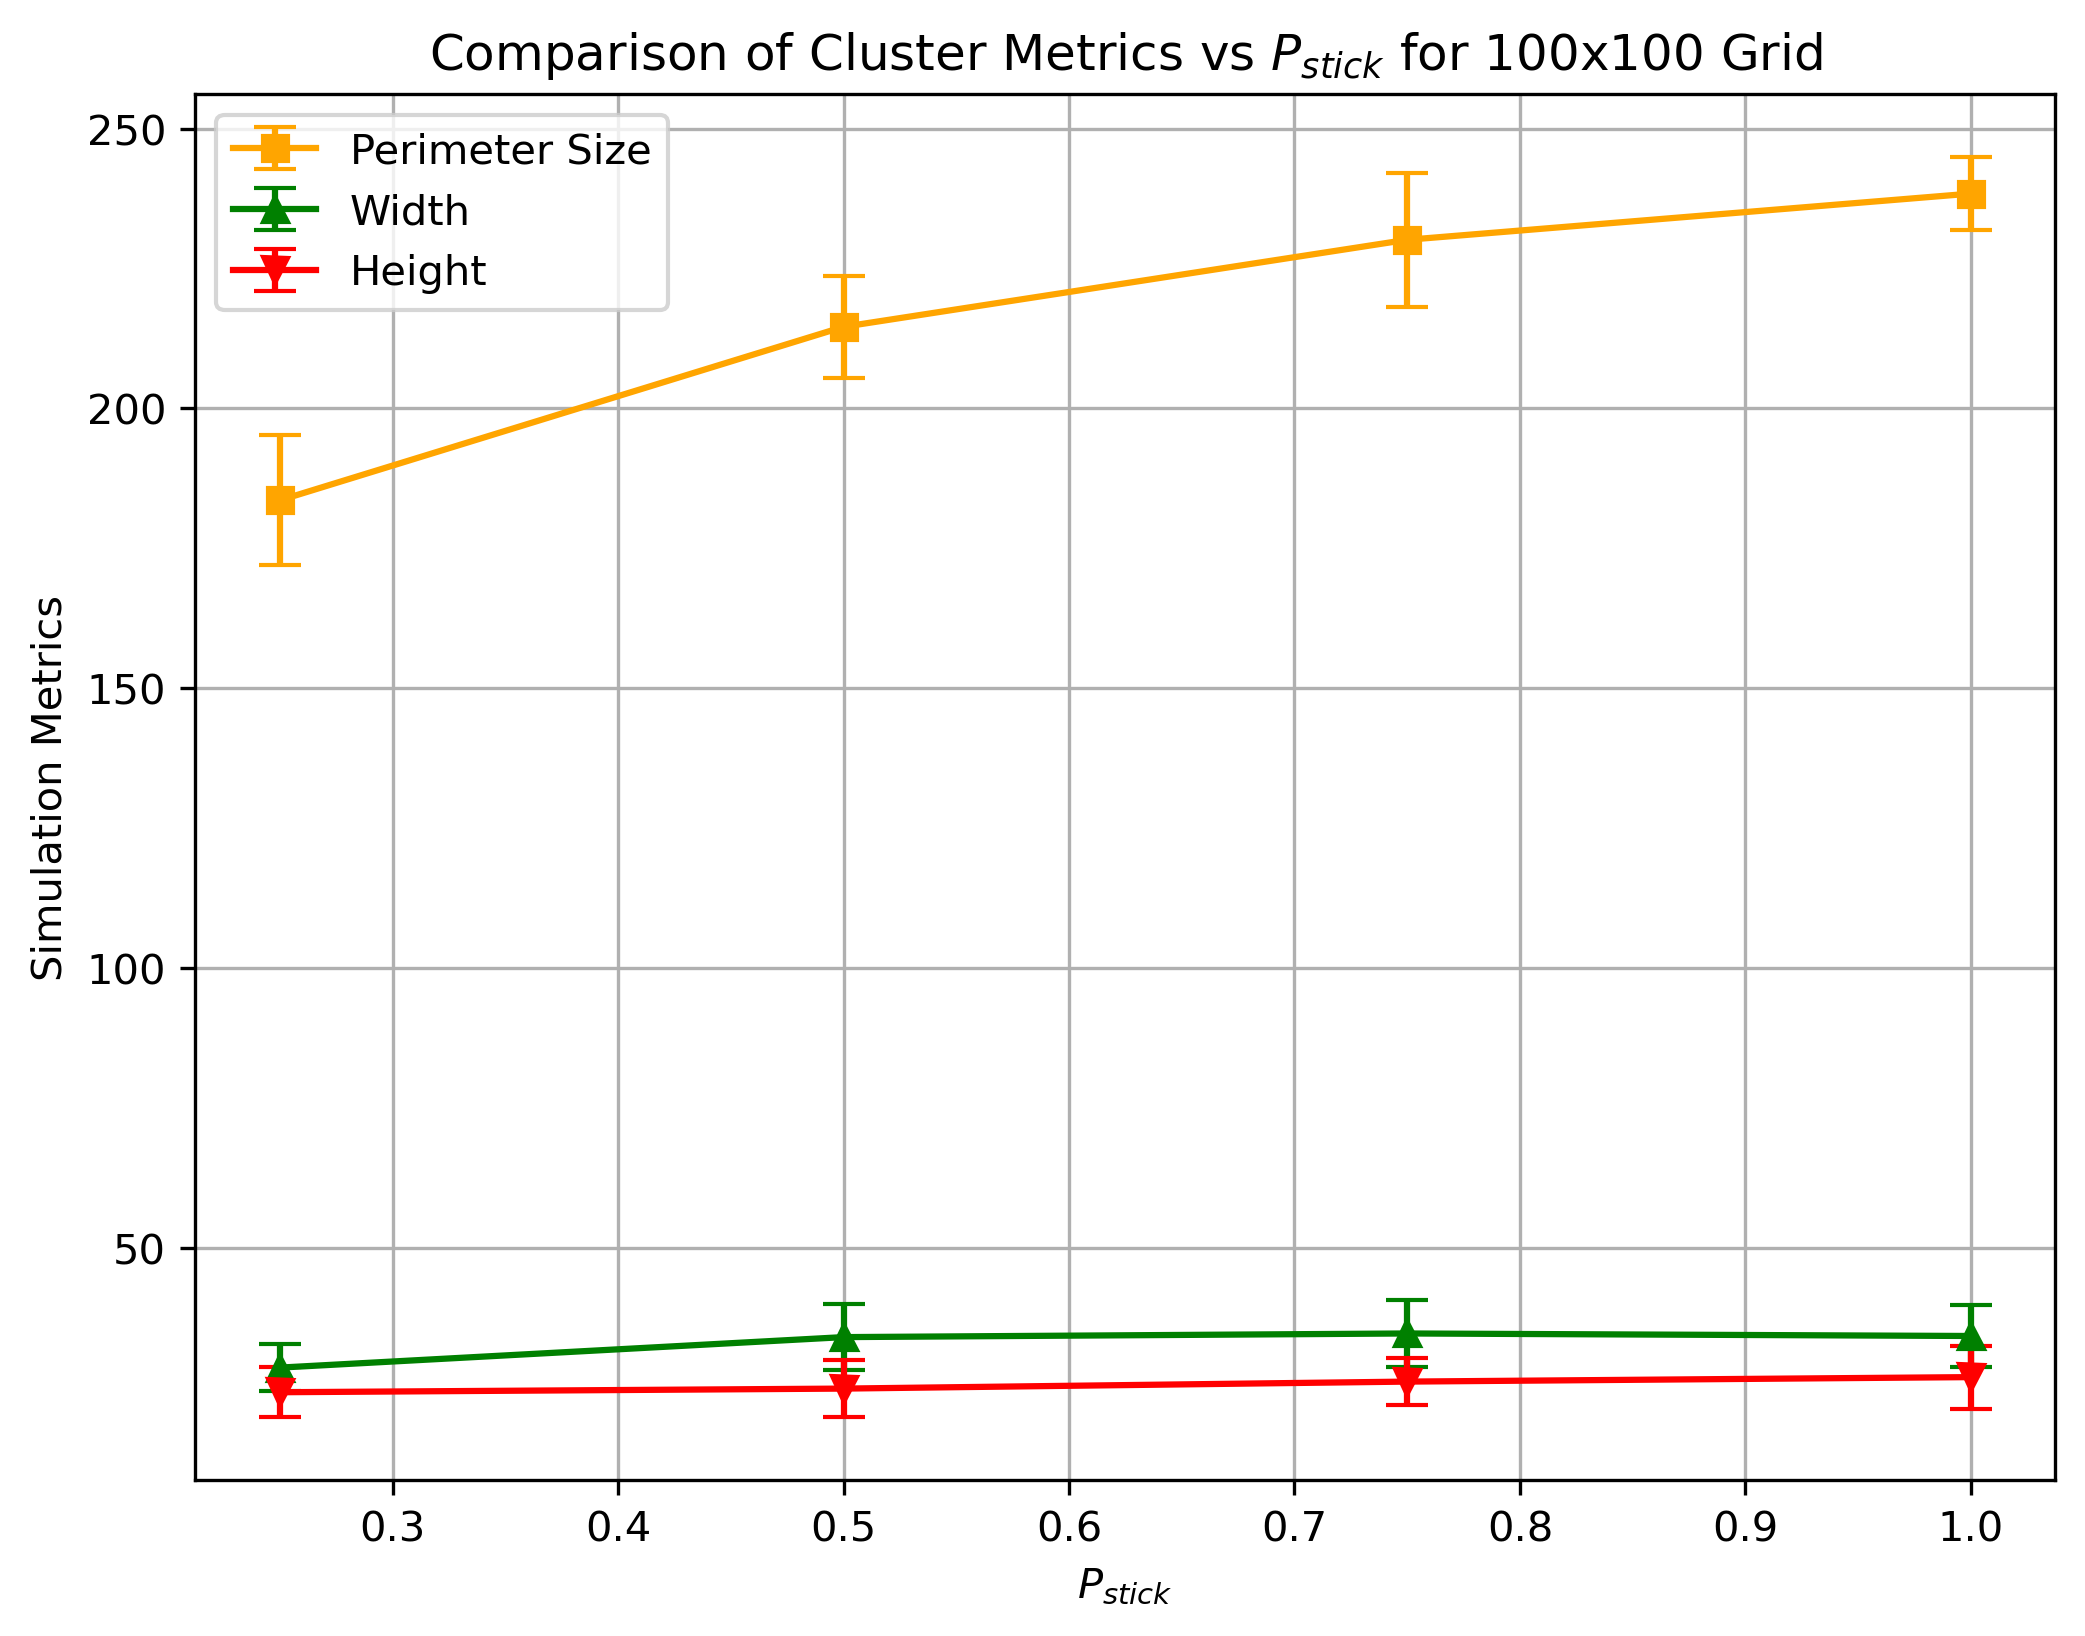

In [12]:

p_stick_values = df["p_stick"].values 


mean_cluster_sizes = df["mean_cluster_size"].values
std_cluster_sizes = df["std_cluster_size"].values

mean_perimeter_sizes = df["mean_perimeter_size"].values
std_perimeter_sizes = df["std_perimeter_size"].values

mean_widths = df["mean_width"].values
std_widths = df["std_width"].values

mean_heights = df["mean_height"].values
std_heights = df["std_height"].values


plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.errorbar(p_stick_values, mean_perimeter_sizes, yerr=std_perimeter_sizes, fmt='s-', capsize=5, label=r'Perimeter Size', color="orange")
plt.errorbar(p_stick_values, mean_widths, yerr=std_widths, fmt='^-', capsize=5, label=r'Width', color="green")
plt.errorbar(p_stick_values, mean_heights, yerr=std_heights, fmt='v-', capsize=5, label=r'Height', color="red")

plt.xlabel(r'$P_{stick}$')
plt.ylabel('Simulation Metrics')
plt.title(r'Comparison of Cluster Metrics vs $P_{stick}$ for 100x100 Grid')
plt.legend()
plt.grid(True)
plt.savefig(f"results/RW_cluster_metrics.png", dpi=300, bbox_inches="tight")

plt.show()

-------
# Chemical Reaction Diffusion

In [3]:
from modules.gray_scott import create_gif, simulate_gray_scott

In [4]:
N = 100
steps = 3_000

Du = 0.16
Dv = 0.08
F = 0.035
k = 0.06
dx = 1
dt = 1

In [ ]:
simulate_gray_scott(
    N,
    Du,
    Dv,
    F,
    k,
    dx,
    dt,
    steps,
    chemical="v",
    boundary="neumann",
    info=True,
    noise_u=True,
    noise_v=False,
)
create_gif("results", "results/gray_scott1.gif")
HTML('<img src="results/gray_scott1.gif">')

Gray-Scott simulation: 100%|██████████| 3000/3000 [00:12<00:00, 246.47it/s]


In [ ]:
simulate_gray_scott(
    N,
    Du,
    Dv,
    F,
    k,
    dx,
    dt,
    steps,
    chemical="v",
    boundary="neumann",
    info=True,
)
create_gif("results", "results/gray_scott2.gif")
HTML('<img src="results/gray_scott2.gif">')

In [ ]:
Du = 0.02
Dv = 0.01
F = 0.034
k = 0.095
dx = 0.1
dt = 0.1

simulate_gray_scott(
    N, Du, Dv, F, k, dx, dt, steps, chemical="u", boundary="neumann", info=True
)
create_gif("results", "results/gray_scott3.gif")
HTML('<img src="results/gray_scott3.gif">')

In [ ]:
Du = 0.01
Dv = 0.005
F = 0.04
k = 0.06
dx = 1
dt = 0.1

simulate_gray_scott(
    N, Du, Dv, F, k, dx, dt, steps, chemical="u", boundary="neumann", info=True
)
create_gif("results", "results/gray_scott4.gif")
HTML('<img src="results/gray_scott4.gif">')